In [1]:
# This line will add a button to toggle visibility of code blocks,
# for use with the HTML export version
from IPython.core.display import HTML
HTML('''<button style="margin:0 auto; display: block;" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle();">Toggle code</button>''')

<img src="./Images/UoE_Horizontal_Logo_282_v1_160215.png" alt="drawing" width="600"/>

# Week 8 - Support Vector Machines
__Dr. David Elliott__

1. [Introduction](#intro)

2. [What is a Hyperplane?](#hyperplane)

3. [Maximal Margin Classifier](#MMC)

__Common Notation__

- $X$ is a matrix containing all the feature values of all the observations
- $n$ is the number of observations in the dataset
- $\mathbf{x}_i$ is a vector of all the feature values (except the label) of the $i$th instance in the dataset.
- $y_i$ is the label (desired model output) of the $i$th instance in the dataset.
- $p$ is the number of features in the dataset
- $\mathbf{x}_j$ is a vector of all the observations values of the $j$th feature in the dataset.

# 1. Introduction <a id='intro'></a>

The term Support Vector Machines (SVM's) is sometimes used loosely to refer to three methods, each an extension of the previous method$^1$:

- Maximal margin classifier,
- Support vector classifier,
- Support vector machine. 

SVM's are a common supervised discriminative algorithm, well suited to *complex* small- to medium sized datasets$^2$.

They can be used for both __classification__ and regression.

In [2]:
%matplotlib inline

import os # locating directories

import numpy as np   # Arrays
import pandas as pd  # DataFrames

# Plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 30000000.0
import seaborn as sns; sns.set()

from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")

# Initial fig number
fig_num = 0

plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

In [3]:
# Centered figures in the notebook and presentation
# ...was a real pain to find this:
# https://gist.githubusercontent.com/maxalbert/800b9f06c7b2dd365ea5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
import base64
from io import BytesIO, StringIO

def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

## Dataset Example: Iris <a id='data'></a>

To demonstrate SVM's I'll be using Fisher's (or Anderson's) Iris flowers dataset$^3$.

The dataset consists of 50 samples each from three species of Iris (Iris setosa, Iris virginica and Iris versicolor).

__Notes__

- _"...This data comes from a famous experiment on a series of measurements of three species of iris flowers. R A Fisher, a statistically minded thinker in the early twentieth centure used this dataset in his 1936 paper The Use of multiple measurements in taxonomic problems, published in the Annals of Eugenics."_$^9$

Figure 1: Iris Flowers


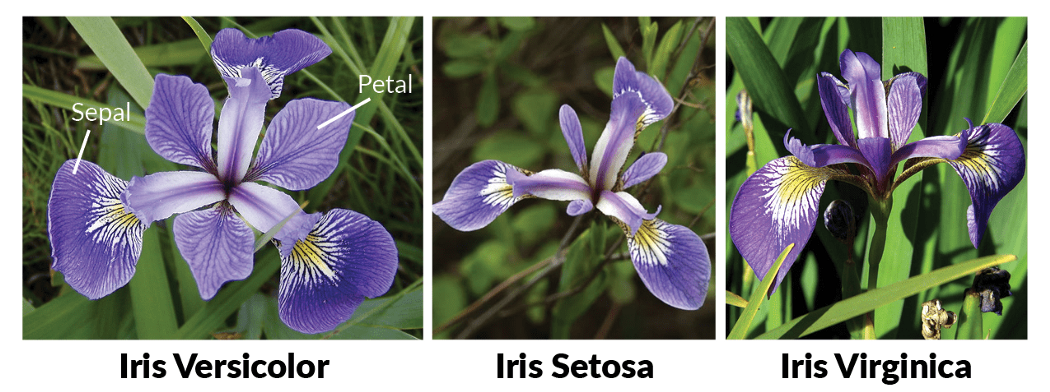

In [4]:
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Iris Flowers" %(fig_num)+color.END)
# Image from: https://www.ritchieng.com/machine-learning-iris-dataset/
display(Image(os.path.join(image_dir,"iris_flowers.png"), height = height_pix, width=width_pix))

Five attributes were collected for the 150 records.

In [5]:
iris = load_iris(as_frame=True)  # data stored in a `sklearn.utils.Bunch`
iris_df = iris['data']           # get features DataFrame
target = iris['target']          # get target Series
display(iris_df.head())             # display the first few rows

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [6]:
# get the labels of flowers capitalised for visualisation
target_names = list(map(lambda s: s.capitalize(), iris['target_names']))

# create a dictionary with the original labels decoded (inverse of LabelEncoder)
decode_label = dict(zip(range(3), target_names))

# make a label encoder to use later if needed
le = LabelEncoder().fit(target_names)
# display the labels
decode_label

{0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

In [7]:
# add the target labels to df for visualisation purposes
iris_vis = pd.concat([iris_df, target],axis=1)
# turn the ints to labels
iris_vis["species"] = iris_vis["target"].replace(decode_label)
# drop the binary labels for the visualisation data
iris_vis = iris_vis.drop('target',axis=1)
# Capitalize column names for plotting
iris_vis.columns = [x.capitalize() for x in list(iris_vis.columns)]
# display the first few rows
iris_vis.head()

Sepal length (cm)  Sepal width (cm)  Petal length (cm)  Petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  Species  
0  Setosa  
1  Setosa  
2  Setosa  
3  Setosa  
4  Setosa

__Notes__

- Species is the typical target for its use in classification

Figure 2: Iris Attributes


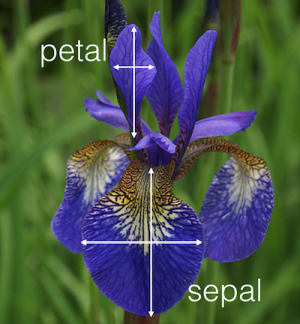

In [8]:
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Iris Attributes"%(fig_num)+color.END)
# Image from: https://www.ritchieng.com/machine-learning-iris-dataset/
display(Image(os.path.join(image_dir,"iris_attributes.png")))

In [9]:
g = sns.pairplot(iris_vis, hue="Species", height=height_inch/2, aspect = gr)
fig_num+=1
plt.suptitle("Figure %d: Iris Flower Dataset Pairplot"%(fig_num), y=1.02)
plt.close()
fig = g.fig
display(MatplotlibFigure(fig, centered=True))

In [10]:
# reduce the data for example
X_AX_LABEL = "Petal length (cm)"
Y_AX_LABEL = "Petal width (cm)"
REMOVE = "Virginica"

iris_reduced = iris_vis[[X_AX_LABEL, Y_AX_LABEL, "Species"]]
iris_reduced = iris_reduced[iris_reduced.Species != REMOVE]

# get the names of the flowers
flowers = list(iris_reduced.Species.unique())

def reduced_plot(X, x_ax_label, y_ax_label, title=None, scale=1):
    sns.set(font_scale = scale)
    # make scatterplot
    g = sns.scatterplot(data=X, x = x_ax_label, y = y_ax_label, 
                        hue="Species", style = "Species", s=60*scale
                       )
    
    # set the title
    if title:
        plt.title(title)
    
    # remove the legend title
    g.axes.get_legend().set_title(False)
    
    return g
    
fig_num+=1
fig = plt.figure(figsize=(width_inch*2, height_inch*2))
g = reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, 
             "Figure %d: "%(fig_num)+X_AX_LABEL+" and "+Y_AX_LABEL+" of \n"+flowers[0]+" and "+flowers[1]+" flowers",
                scale=2)
plt.close()
display(MatplotlibFigure(fig, centered=True))

In [11]:
# Altered https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.svm import SVC
x0 = np.linspace(0, 5.5, 200)
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

X = iris_reduced[[X_AX_LABEL, Y_AX_LABEL]].values
y = le.transform(iris_reduced[["Species"]].values.ravel())

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)
w = svm_clf.coef_[0]
b = svm_clf.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0
# => x1 = -w0/w1 * x0 - b/w1
x0 = np.linspace(0, 5.5, 200)
pred_1 = -w[0]/w[1] * x0 - b/w[1]

def example_lines(X, x_ax_label, y_ax_label, title, pred_lines, axes_limit = [0, 5.5, 0, 2]):
    reduced_plot(X, x_ax_label, y_ax_label, title, scale=2)
    
    line_styles=["g-", "m-", "r-"]
    for i, pred_line in enumerate(pred_lines):
        plt.plot(x0, pred_line, line_styles[i], linewidth=2)
        
    plt.axis(axes_limit)

fig_num+=1
fig = plt.figure(figsize=(width_inch*2, height_inch*2))
example_lines(iris_reduced, X_AX_LABEL, Y_AX_LABEL, 
              "Figure %d: Potential Decision Boundaries"%(fig_num),
              [pred_1, pred_2, pred_3])

plt.close()
display(MatplotlibFigure(fig, centered=True))

__Notes__

- We could use any one of the decision boundries above to separate the flower classes, but which one if the "best"?

In [12]:
# Altered https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def svc_decision_boundary(clf, xmin=0, xmax=5.5, highlight=True, axes_limit = [0, 5.5, 0, 2], scale=1):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    if highlight:
        g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180*scale, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "g-", linewidth=2)
    plt.plot(x0, gutter_up, "r--", linewidth=2)
    plt.plot(x0, gutter_down, "r--", linewidth=2)
    
    plt.axis(axes_limit)

# SVM Classifier model
svm_clf = SVC(kernel="linear", 
              C=float("inf") # Inf is for demo purposes (dont use in practice!)
             )
svm_clf.fit(X, y)

fig_num+=1
fig = plt.figure(figsize=(width_inch*2, height_inch*2))
svc_decision_boundary(svm_clf, scale=2)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, 
             "Figure %d: Support Vector Hyperplane and Margin"%(fig_num), scale=2)
plt.close()
display(MatplotlibFigure(fig, centered=True))

__Notes__

- The middle thick line is a <span style="color:green">hyperplane</span> and the dashed outer lines are the edges of the <span style="color:red">margin</span>.
- The circled points are the class examples that fall on the margin. These will later be termed _support vectors_.

# 2. What is a Hyperplane? <a id='hyperplane'></a>
In $p$-dimensional space, a hyperplane is a flat affine subspace of dimension $p-1$.

- *Two-dimensions*: A flat one-dimensional line
- *Three-dimensions*: A two-dimensional subspace
- *p-dimensions*: A $p-1$ dimensional subspace

__Notes__

- "Affine" just means _"does not need to pass through the origin"_

- *Two-dimensions*: Figures 5 & 6
- *Three-dimensions*: Figure 7
- *p-dimensions*: ...you'll have to use your imagination

- If you want to interact with the 3D plot use `%matplotlib notebook`

In [13]:
# Three Dimension
def three_dim(title):
    sns.set(font_scale=0.8)
    with sns.axes_style("white"):
        
        X = iris.data.values[:, :3]  # we only take the first three features.
        Y = iris.target

        # make it binary classification problem
        X = X[np.logical_or(Y==0,Y==1)]
        Y = Y[np.logical_or(Y==0,Y==1)]
        
        ax = fig.add_subplot(111, projection = '3d')

        # SVM
        model = SVC(kernel='linear')
        clf = model.fit(X, Y)

        # The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
        # Solve for w3 (z)
        z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

        xm, xM = X[:,0].min(), X[:, 0].max()
        ym, yM = X[:,1].min(), X[:, 1].max()

        number_of_squares = 10
        x = np.linspace(xm, xM, number_of_squares)
        y = np.linspace(ym, yM, number_of_squares)
        x, y =np.meshgrid(x, y)
        ax.plot_surface(x, y, z(x,y), alpha=0.5)

        x = X[:, 0]
        y = X[:, 1]
        z = X[:, 2]

        ax.set_xlabel(iris_df.columns[0], fontsize=7)
        ax.set_ylabel(iris_df.columns[1], fontsize=7)
        ax.set_zlabel(iris_df.columns[2], fontsize=7)

        ax.scatter(x, y, z, c=Y, cmap="PuOr")

        ax.view_init(elev=23., azim=168.)

        plt.suptitle(title, fontsize=7, y=0.85)

fig_num+=1
fig = plt.figure(figsize=(width_inch, height_inch))
three_dim("Figure %d: Support Vector Hyperplane in Three Dimensions"%(fig_num))
plt.close()
display(MatplotlibFigure(fig, centered=True))

In more detail$^1$:

*Two-dimensions*: $\beta_0 + \beta_1\mathbf{x}_1 + \beta_2\mathbf{x}_2 = 0$

*Three-dimensions*: $\beta_0 + \beta_1\mathbf{x}_1 + \beta_2\mathbf{x}_2 + \beta_3\mathbf{x}_3 = 0$

*P-dimensions*: $\beta_0 + \beta_1\mathbf{x}_1 + \beta_2\mathbf{x}_2 + ... + \beta_p\mathbf{x}_p = 0$

<br />

If $x = (\mathbf{x}_1, ..., \mathbf{x}_p)$ satisfies above, then it is a point on the hyperplane.

<br />

If $\beta_0 + \beta_1\mathbf{x}_1 + \beta_2\mathbf{x}_2 + ... + \beta_p\mathbf{x}_p > 0$, it lies on one side of the hyperplane,

so if, $\beta_0 + \beta_1\mathbf{x}_1 + \beta_2\mathbf{x}_2 + ... + \beta_p\mathbf{x}_p < 0$, its on the other side. 

__Notes__

- In-other-words, $p$-dimensional space is dividided into two halves.

### Classifying data
We aim to classify an $n \times p$ matrix of $n$ observations in $p$ dimensional space, with these observations falling into two classes $y_1,...,y_n \in \{-1,1\}$.

If we were to perfectly separate the classes the hyperplane would have the property that$^1$:

$\beta_0 + \beta_1\mathbf{x}_{i1} + \beta_2\mathbf{x}_{i2} + ... + \beta_p\mathbf{x}_{ip} > 0 \quad \text{if} \ y_i = 1$,

$\beta_0 + \beta_1\mathbf{x}_{i1} + \beta_2\mathbf{x}_{i2} + ... + \beta_p\mathbf{x}_{ip} < 0 \quad \text{if} \ y_i = -1$.

<br />

For a new test observations $x^*$, we would look at the sign of:

$$f(x^*) = \beta_0 + \beta_1x_1^* + \beta_2x_2^* + ... + \beta_px_p^*.$$

We would assign it to class 1 if $f(x^*)$ is positive and class -1 if negative.

Furthermore, we could use the magnitude of $f(x^*)$ to indicate how far the point lies from the hyperplane.

# 3. Maximal Margin Classifier <a id='MMC'></a>
We need a reasonable way of constucting a hyperplane, out of the possible choices.

Maximal margin hyperplanes look at getting the hyperplane that is the furthest from the training observations - we compute the perpendicular distance from each training observation to a given separating hyperplane. 

The maximal margin hyperplane is the separating hyperplane for which the margin is largest.

We hope the classifier with a large margin on the training data will generalise well to unseen test observations.

Another way of defining our hyperplane is:

$$\mathbf{w} \cdot \mathbf{x} + b = 0,$$

which uses the dot product between a weight vector, $\mathbf{w}$, and our input vector $\mathbf{x}$, plus our bias, $b$ (sometimes defined as $w_0$).

In statistics the dot product of two n-dimensional vectors $\mathbf{a}$ and $\mathbf{b}$ is often noted as $\mathbf{a} \cdot \mathbf{b}$. The dot product is a type of _inner product_, often denoted as $\left<\mathbf{a},\mathbf{b}\right>$.

__Notes__

- $\mathbf{a} \cdot \mathbf{b} = \sum\limits^n_{i=1}\mathbf{a}_i\mathbf{b}_i$

In Machine Learning, vectors are typically represented as _column vectors_, so the dot product is defined as $\mathbf{a}^{\mathrm T} \mathbf{b}$. Using this notation, our hyperplane is$^{10}$:

$$\mathbf{w}^{\mathrm T}\mathbf{x} + b = 0.$$

Our margins, where our labels $y \in \{-1,1\}$, are then:

$$
\mathbf{w}^{\mathrm T}\mathbf{x}_i + b \geq 1 \text{ if } y_i = 1, \\
\mathbf{w}^{\mathrm T}\mathbf{x}_i + b \leq -1 \text{ if } y_i = -1, \\
\text{for } i = 1,\ldots,n,
$$

which can be more compactly written as:
$$
y_i\left(\mathbf{w}^{\mathrm T}\mathbf{x}_i + b\right) \geq 1 \quad \forall_i
$$

In [14]:
def plot_svc_margin(clf, xmin=0, xmax=5.5, highlight=False, highlight_line=False, 
                    margin_line=False, axes_limit= [0, 5.5, 0, 2], ax = None, scale=1):
    sns.set(font_scale = scale)
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    
    with sns.axes_style("dark"):
        if ax:
            plt.sca(ax)
        else:
            fig = plt.figure(figsize = (width_inch*scale, height_inch*scale))
        plt.fill_between(x0, gutter_down, facecolors='white')
        plt.fill_between(x0, gutter_up, xmax, facecolors='white')
        if highlight:
            g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180*scale, facecolors='#FFAAAA')
        if margin:
            plt.plot(x0, decision_boundary, "g-", linewidth=2*scale, alpha=0.3)
        else:
            plt.plot(x0, decision_boundary, "g-", linewidth=2*scale)
        plt.plot(x0, gutter_up, "r--", linewidth=2*scale)
        plt.plot(x0, gutter_down, "r--", linewidth=2*scale)
        
        # I've been a bit lazy here and not drawn the lines properly
        
        if highlight_line or margin_line:
            plt.arrow(svs[0, 0],svs[0, 1], 0.7, 0.125, fc='k', ec='k', linewidth=1*scale, length_includes_head=True)
            plt.arrow(svs[1, 0],svs[1, 1], -0.7, -0.125, fc='k', ec='k', linewidth=1*scale, length_includes_head=True)
        
        if highlight_line:
            plt.text(svs[0, 0],svs[0, 1]+0.1, r'$ x_2 $')
            plt.text(svs[1, 0],svs[1, 1]+0.1, r'$ x_1 $')
        
        if margin_line:
            plt.arrow(2.1, 0.05, 1.4, 0.25, fc='y', ec='y', linewidth=1*scale, linestyle=':',length_includes_head=True)
            plt.text(2.55, 0.22, r'$ \frac{2}{||w||} $', fontsize=15*scale, rotation=20)
            plt.text(svs[0, 0]-0.04,svs[0, 1]+0.04, r'$ w^Tx_2 + b = -1 $', fontsize=8*scale, rotation=18)
            plt.text(svs[1, 0]-0.7,svs[1, 1]-0.08, r'$ w^Tx_1 + b = 1 $', fontsize=8*scale, rotation=18)
        
    plt.axis(axes_limit)
    
    if not ax:
        return fig

fig_num+=1
#plt.figure(figsize=(width_inch, height_inch))
fig = plot_svc_margin(svm_clf, scale=2)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, 
             "Figure %d: Support Vector Margin"%(fig_num), scale=2)
plt.close()
display(MatplotlibFigure(fig, centered=True))

There are two equidistant points from the maximal margin hyperplane, lying on the dashed lines. These observations are called *Support Vectors*.

We can call these two points, $x_1$ and $x_2$ as below:

$$\mathbf{w}^{\mathrm T}x_1 + b = 1,$$

$$\mathbf{w}^{\mathrm T}x_2 + b = -1.$$

In [15]:
fig, ax = plt.subplots(figsize = (width_inch, height_inch))
plot_svc_margin(svm_clf, highlight=True, highlight_line=True, ax=ax)
fig_num+=1
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, "Figure %d: Support Vectors"%(fig_num))
plt.close()
display(MatplotlibFigure(fig, centered=True))

If we move our support vectors our hyperplane will too.

This is because the maximal margin hyperplane only depends on these support vectors. 

Other data points could be moved without the hyperplane moving.

In [17]:
# get a list of support vector indexes
S_i = list(svm_clf.support_)

X = iris_reduced.drop(S_i)[[X_AX_LABEL, Y_AX_LABEL]].values
y = le.transform(iris_reduced.drop(S_i)[["Species"]].values.ravel())

svm_clf2 = SVC(kernel="linear", 
              C=float("inf") # Inf is for demo purposes (dont use in practice!)
             )
svm_clf2.fit(X, y)

fig, ax = plt.subplots(1,2, figsize = (width_inch*2, height_inch), sharey=True)
ax = ax.flatten()
plot_svc_margin(svm_clf, highlight=True, ax=ax[0], scale =1)
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL)
plot_svc_margin(svm_clf2, highlight=True, ax=ax[1], scale =1)
reduced_plot(iris_reduced.drop(S_i), X_AX_LABEL, Y_AX_LABEL, scale =1)
fig_num+=1
plt.suptitle('Figure %d: Changing the Maximal Margin'%(fig_num))
plt.close()
display(MatplotlibFigure(fig, centered=True))

We want to maximise the distance between the margin lines, on which the points lie$^{10}$.

$$x_1-x_2$$

<br />
$$
\frac{\phantom{\quad}\mathbf{w}^{\mathrm T}x_1 + b = 1\\ - 
\mathbf{w}^{\mathrm T}x_2 + b = -1 \\}{\\ \mathbf{w}^{\mathrm T}(x_1 - x_2) = 2}
$$

<br />
We can normalise this equation by the length (Euclidean norm) of the vector $\mathbf{w}$:

$$
||\mathbf{w}|| = \sqrt{\sum^p_{j=1}w^2_j}
$$

$$
\frac{\mathbf{w}^{\mathrm T}(x_1 - x_2)}{||\mathbf{w}||} = \frac{2}{||\mathbf{w}||}
$$

__Notes__
1. we want the distance between $x_1$ and $x_2$
2. our $b$ cancels out
3. we want to remove $\mathbf{w}^{\mathrm T}$
4. we do this with norm of $\mathbf{w}^{\mathrm T}$. However we cannot remove $||\mathbf{w}||$, so we are left to maximise $\frac{2}{||\mathbf{w}||}$.

In [18]:
fig = plot_svc_margin(svm_clf, highlight=True, margin_line=True, scale=2)
fig_num+=1
reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, 
             "Figure %d: Margin Distances"%(fig_num))
plt.close()
display(MatplotlibFigure(fig, centered=True))

We want to $\text{max}\frac{2}{||\mathbf{w}||}$, while classifying everything correctly, $y_i(\mathbf{w}^{\mathrm T}\mathbf{x}_i+b) \geq 1 \quad \forall_i$.

Or, instead:

${\text{min} \atop \mathbf{w}, b}\frac{1}{2}||\mathbf{w}||^2 \quad \text{s.t.} \quad y_i(\mathbf{w}^{\mathrm T}\mathbf{x}_i+b) \geq 1 \quad \forall_i$,

which is easier because this is a _convex quadratic optimisation problem_ which is efficiently solvable using quadratic programming algorithms. 

__Notes__

- $\frac{1}{2}$ is added for convience.

### Primal Problem

This requires a _Lagrangian_ formulation of the problem so we introduce Lagrange multipliers, $\alpha_i, i = 1, \ldots , n$:

$$
\min L_P = \frac{1}{2}||\mathbf{w}||^2 - \sum^n_{i=1} \alpha_iy_i(\mathbf{w}^{\mathrm T}\mathbf{x}_i+b) + \sum^n_{i=1} \alpha_i \qquad \text{s.t.} \quad \forall_i \alpha_i \geq 0
$$

### Duel Problem$^{2,6,7}$

Removes the dependence on $\mathbf{w}$ and $b$,

$$
\max L_D = \sum_i^n\alpha_i - \frac{1}{2}\sum_i^n\sum_k^n\alpha_i\alpha_ky_iy_k\mathbf{x}_i^{\mathrm T} \mathbf{x}_k \qquad \text{s.t.} \quad \forall_i \alpha_i \geq 0.
$$

To achive this we first need to set a constaint,

$$\sum^n_i\alpha_iy_i = 0.$$

Now we can find the vector $\hat\alpha$ that maximises the equasion using a _QP solver_.

__Notes__

- The duel problem allows us later to use the kernel trick.
- $\sum_i\alpha_iy_i = 0$ removes our $b$.
- There is a Lagrange multiplier $\alpha_i$ for every training point. Points for which $\alpha_i > 0$ are called "support vectors", and lie on one of the margins, with all other training points having $\alpha_i = 0$.
- $\alpha_i$ will only be zero if all training points have the same class.

Knowing our $\hat\alpha_i$ means we can find the weights, $\mathbf{\hat w}$, which are a linear combination of the training inputs, $\mathbf{x}_i$, training outputs, $y_i$, and the values of $\alpha$,

$$\mathbf{\hat w} = \sum_{i \in s}\hat\alpha_iy_i\mathbf{x}_i,$$

where $s$ is the collection of indicies of support vectors$^6$. We only need the support vectors as they are the only ones with $\hat\alpha_i > 0$.

Out bias term, $\hat b$, is then determined by$^2$:
$$
\hat b = \frac{1}{n_s}\sum^n_{i =1}\left(y_i-\mathbf{\hat w}^{\mathrm T}\mathbf{x}_i\right)
$$
where $n_s$ is the number of support vectors.

__Notes__

- We only need to focus on those with $\alpha_i > 0$.
- Solving the SVM problem is equivalent to finding a solution to the Karush-Kuhn-Tucker (KKT) conditions.
    - it is through the use of using the following Karush-Kuhn-Tucker (KKT) condition we can find $b$:
$$
\alpha_i(y_i(\mathbf{w} \cdot \mathbf{x}_i + b) - 1) = 0 \quad \forall i.
$$
- It is numerically safer to take the average value over all support vectors, $\frac{1}{N_S}$.
- For more reading on quadratic programming for support vector machines, I recommend you read:
    - Appendix C in Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
    - Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
    - https://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-duality-problem/

## Inner products, similarity, and SVMs$^8$

__Question__: But why bother doing this? That was a lot of effort, why not just solve the original problem?

__Answer__: Because this will let us solve the problem by computing the just the inner products ($\mathbf{x}_i^{\mathrm T} \mathbf{x}_k$) which will be important when we want to solve non-linearly separable classification problems.

- Inner products provide a measure of _"similarity"_
- Inner product in 2D between 2 vectors of unit length returns the cosine of the angle between them. In otherwords, how _"far apart"_ they are.
    - if they are parallel their inner product is 1 (completely similar).
    - If they are perpendicular (completely unlike) their inner product is 0 (so should not contribute to the correct classifier).

$$
L_D(\alpha_i) = \sum_i^n\alpha_i - \frac{1}{2}\sum_{i,k}^n\alpha_i\alpha_ky_iy_k\mathbf{x}_i^{\mathrm T} \mathbf{x}_k \qquad \text{s.t.} \quad \forall_i \alpha_i \geq 0, \ \sum_i^n\alpha_iy_i = 0.
$$

__Case 1__
Two observations $\mathbf{x}_i$, $\mathbf{x}_k$ are completely _dissimilar_ (orthogonal), so their dot product is 0. They don't contribute to $L$.

__Case 2__ Two observations $\mathbf{x}_i$, $\mathbf{x}_k$ are similar and predict the _same_ output value $y_i$ (ie. both $+1$ or $-1$). This means $y_i \times y_k = 1$ and the value $\alpha_i\alpha_ky_iy_k\mathbf{x}_i\mathbf{x}_k$ is positive. However this _decreases_ the value of $L$, due to subtracting from the first term sum, $\sum_i^n\alpha_i$, so the algorithm downgrades similar feature vectors that make the _same_ prediction.

__Case 3__ : Two observations $\mathbf{x}_i$, $\mathbf{x}_k$ predict opposite predictions about the output value $y_i$ (ie. one $+1$ and the other $-1$), but are otherwise similar. The value $\alpha_i\alpha_ky_iy_k\mathbf{x}_i\mathbf{x}_k$ is negative and since we are subtracting it, this adds to the sum. These are the examples that maximise the margin width.

In [19]:
# TODO - this is pretty quick code - tidy it up
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def plot_svc_case_example(clf, main_title, axes_limit= [-2, 5.5, 0, 4]):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    xmin=axes_limit[0]
    xmax=axes_limit[1]
    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    
    with sns.axes_style("whitegrid"):

        fig, axes = plt.subplots(1,3, figsize = (width_inch*3, height_inch), sharey=True)
        axes = axes.flatten()
        
        for i, title in enumerate(["Case 1","Case 2", "Case 3"]):
            plt.sca(axes[i])
        
            if title == "Case 1":
                orth = rotate((0,0), svs[0, :], 1.5708)
                sns.scatterplot(x = [orth[0]], y = [orth[1]], s=180, facecolors='#FFAAAA')
                sns.scatterplot(x = [svs[0, 0]], y = [svs[0, 1]], s=180, facecolors='#FFAAAA')
                plt.arrow(0.,0,svs[0, 0],svs[0, 1], fc='b', ec='b', linewidth=1, length_includes_head=True)
                plt.arrow(0.,0,orth[0],orth[1], fc='b', ec='b', linewidth=1, length_includes_head=True)
                iris_reduced_ = pd.concat([iris_reduced, pd.DataFrame([orth[0],orth[1], "Setosa"],index = iris_reduced.columns).T])
                reduced_plot(iris_reduced_, X_AX_LABEL, Y_AX_LABEL, title)
            
            else:
                if title == "Case 3":
                    g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180, facecolors='#FFAAAA')
                    plt.arrow(0.,0,svs[0, 0],svs[0, 1], fc='b', ec='b', linewidth=1, length_includes_head=True)
                    plt.arrow(0.,0,svs[1, 0],svs[1, 1], fc='orange', ec='orange', linewidth=1, length_includes_head=True)

                else:
                    sns.scatterplot(x = [svs[0, 0]], y = [svs[0, 1]], s=180, facecolors='#FFAAAA')
                    sns.scatterplot(x = [iris_reduced.iloc[24,0]], y = [iris_reduced.iloc[24,1]], s=180, facecolors='#FFAAAA')
                    plt.arrow(0.,0,svs[0, 0],svs[0, 1], fc='b', ec='b', linewidth=1, length_includes_head=True)
                    plt.arrow(0.,0,iris_reduced.iloc[24,0],iris_reduced.iloc[24,1], fc='b', ec='b', linewidth=1, length_includes_head=True)
                
                reduced_plot(iris_reduced, X_AX_LABEL, Y_AX_LABEL, title)
            plt.axis(axes_limit)
            
            plt.plot(x0, decision_boundary, "g-", linewidth=2)
            plt.plot(x0, gutter_up, "r--", linewidth=2)
            plt.plot(x0, gutter_down, "r--", linewidth=2)
            
            axes[i].get_legend().remove()
        
        
        fig.suptitle(main_title, y=1.05)
        
        return fig
        
fig_num+=1
fig = plot_svc_case_example(svm_clf, "Figure %d: Similarities and SVM"%(fig_num))
plt.close()
display(MatplotlibFigure(fig, centered=True))

## Recap$^1$

The solution to the maximal margin classifier problem involves only the _inner products_ of the observations:

$$
\left<x_i,x_{i^{\prime}}\right> = \sum^p_{j=1}x_{ij}x_{i^{\prime}j}.
$$

Assume we have a new point $x^*$. If wanted to compute $f(x^*)$ using our linear classifier we would need to the inner product between $x^*$ and each training point $x_i$:

$$f(x) = \sum^n_{i=1}\hat\alpha_i\left<x^*,x_i\right>+ \hat b.$$

In the above case, for estimating the parameters $\hat\alpha_1...,\hat\alpha_n$ and $\hat b$, we need the $n(n-1)/2$ inner products $\left<x_i,x_{i^\prime}\right>$ between all pairs of training observations.

However, $\hat\alpha$ is nonzero only for support vectors, so if we have a collection of their indicies, $s$, we can do the following instead:

$$
f(x^*) = \sum_{i\in s}\hat\alpha_i \left<x^*,x_i\right> + \hat b.
$$

## Limitations

- If we have a large number of features, this approach often leads to overfitting.
- Maximal Margin Classifiers are sensitive to outliers. 

In [20]:
# adapted from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def outlier_margin(title, scale=1):
    X = iris_reduced[["Petal length (cm)", "Petal width (cm)"]].values
    y = le.transform(iris_reduced[["Species"]].values.ravel())
    X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
    y_outliers = np.array([0, 0])
    Xo = np.concatenate([X, X_outliers[1:]], axis=0)
    yo = np.concatenate([y, y_outliers[1:]], axis=0)

    svm_clf = SVC(kernel="linear", C=float("inf"))
    svm_clf.fit(Xo, yo)

    svc_decision_boundary(svm_clf, scale=2)
    g = sns.scatterplot(x = Xo[:,0], y = Xo[:,1], hue=yo, style = yo, s=60*scale)
    leg = g.axes.get_legend()
    new_labels = ['Setosa', 'Versicolor']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)
    plt.axis([0, 5.5, 0, 2])
    plt.title(title)
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")
    
fig_num+=1
fig = plt.figure(figsize=(width_inch*1.5, height_inch*1.5))
outlier_margin("Figure %d: Effect of outliers"%fig_num, scale=2)
plt.close()
display(MatplotlibFigure(fig, centered=True))

__Notes__

- In figure 13 above, we can see that the reliance on a small number of observations means there is now a small margin. 
- We want to be confident that a distance from the hyperplane is a measure of our confidence in its classification, and that we have no overfit to our training data.

In other cases, no exact linear separating hyperplane exists. Therefore we may want to use a hyperplane that *almost* separates the two classes, allowing some errors, using a *soft margin* (Support Vector Classifier).

In [21]:
def soft_margin(title, hyperplane=False, scale=1):
    virgin_versi = iris_vis[["Petal length (cm)", "Petal width (cm)", "Species"]]
    virgin_versi = virgin_versi[virgin_versi.Species != "Setosa"]

    X = virgin_versi[["Petal length (cm)", "Petal width (cm)"]].values
    y = virgin_versi[["Species"]].replace({'Versicolor':0, 'Virginica':1}).values.ravel()
    
    if hyperplane:
        svm_clf = SVC(kernel="linear", C=100)
        svm_clf.fit(X, y)

        svc_decision_boundary(svm_clf, 2.9, 7)
    labels = virgin_versi[["Species"]].values.ravel()
    sns.scatterplot(x = X[:,0], y = X[:,1], hue=labels, style = labels, s=60*scale)
    plt.axis([2.9, 7, 0.9, 2.75])
    plt.title(title)
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")

fig_num+=1
fig = plt.figure(figsize=(width_inch*2, height_inch*2))
soft_margin("Figure %d: No Exact Linear Separating Hyperplane"%fig_num, scale=1.5)
plt.close()
display(MatplotlibFigure(fig, centered=True))

# Associated Exercises

Now might be a good time to try exercises 1-4.

# References
1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
3. Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of eugenics, 7(2), 179-188.
5. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.
6. Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
7. Fletcher, R. Practical Methods of Optimization. John Wiley and Sons, Inc., 2nd edition, 1987
8. http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf
9. https://bookdown.org/koehlerj/qr_book/introducing-the-iris-dataset.html
10. Raschka, Sebastian, and Vahid Mirjalili. "Python Machine Learning: Machine Learning and Deep Learning with Python." Scikit-Learn, and TensorFlow. Second edition ed (2017).

In [28]:
import sys
from shutil import copyfile

# where the HTML template is located
dst = os.path.join(sys.prefix, 'lib', 'site-packages', 'nbconvert', 'templates', "classic.tplx")

# If its not located where it should be
if not os.path.exists(dst):
    # uses a nb_pdf_template
    curr_path = os.path.join(os.getcwd(),"..", "Extra", "classic.tplx")
    # copy where it is meant to be
    copyfile(curr_path, dst)

   
# Create HTML notes document (preferred)
!jupyter nbconvert 1_Maximal_Margin_Classifiers.ipynb \
    --to html \
    --output-dir . \
    --template classic
# Create html slides (issues)
!jupyter nbconvert 1_Maximal_Margin_Classifiers.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

# Create pdf notes document (issues)
!jupyter nbconvert 1_Maximal_Margin_Classifiers.ipynb \
    --to html \
    --output-dir . \
    --output 1_Maximal_Margin_Classifiers_no_code \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook 1_Maximal_Margin_Classifiers.ipynb to html
[NbConvertApp] Converting notebook 1_Maximal_Margin_Classifiers.ipynb to slides
[NbConvertApp] Converting notebook 1_Maximal_Margin_Classifiers.ipynb to html
